In [ ]:
!pip install shap

In [2]:
!pip install optuna

In [3]:
## import packages
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np
import pickle

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import shap
import optuna

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_importance
import lightgbm as lgb

from warnings import filterwarnings
filterwarnings('ignore')

In [23]:
## load the training and validation data
train_features = pd.read_csv("train_features.csv")
train_labels = pd.read_csv("train_labels.csv")
validation_features = pd.read_csv("validation_features.csv")
validation_labels = pd.read_csv("validation_labels.csv")

In [24]:
## tranform target value
train_labels = np.log1p(train_labels)

In [ ]:
train_features.drop(columns=['station_precip_mm_rolling_month_median'], inplace=True)
validation_features.drop(columns=['station_precip_mm_rolling_month_median'], inplace=True)

#### LightGBM

In [6]:
### LightGBM time split validation integrated with Optuna
import optuna

def lgb_objective_ts_cv(trial, train_features, train_labels):

  param_grid = {
      "num_iterations": trial.suggest_int("num_iterations", 20, 100, 10),
      "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, step=0.01),
      "num_leaves": trial.suggest_int("num_leaves", 8, 72, step=1),
      "max_depth": trial.suggest_int("max_depth", 3, 8),
      "lambda_l1": trial.suggest_float("lambda_l1", 0.01, 0.1, step=0.01),
      "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100, step=5),
      "bagging_fraction": trial.suggest_float(
          "bagging_fraction", 0.7, 0.95, step=0.01
      ),
      "feature_fraction_bynode": trial.suggest_float(
          "feature_fraction_bynode", 0.7, 0.95, step=0.01
      ),
      "feature_fraction": trial.suggest_float(
          "bagging_fraction", 0.8, 0.95, step=0.01
      )
  }

  tscv = TimeSeriesSplit(n_splits=5)
  folds = tscv.split(train_features)

  dtrain = lgb.Dataset(train_features, label=train_labels)

  param_grid['objective'] = "regression"
  param_grid['metric'] = "l1"
  param_grid['verbosity'] = -1
  param_grid['boosting_type'] = "gbdt"

  lgbcv = lgb.cv(param_grid,
                 dtrain,
                 folds=folds,
                 shuffle=False)

  cv_score = lgbcv['valid l1-mean'][-1] + lgbcv['valid l1-stdv'][-1]

  return cv_score

In [25]:
study = optuna.create_study(
        direction="minimize",
        study_name = "LightGBM Regression"
    )
func = lambda trial: lgb_objective_ts_cv(trial, train_features, train_labels)
study.optimize(func, n_trials = 100)
lgb_parameters = study.best_params

lgb_reg = lgb.LGBMRegressor(**lgb_parameters,
                        random_state = 42)
lgb_reg.fit(train_features, train_labels, eval_metric = mean_absolute_error)
Y_pred = np.expm1(lgb_reg.predict(validation_features)).astype(int).clip(0)

print("\n\nFinal MAE for validation set is {}".format(mean_absolute_error(validation_labels, Y_pred)))

[I 2023-10-30 04:12:16,111] A new study created in memory with name: LightGBM Regression
[I 2023-10-30 04:12:16,396] Trial 0 finished with value: 1.163174577691573 and parameters: {'num_iterations': 60, 'learning_rate': 0.17500000000000002, 'num_leaves': 26, 'max_depth': 6, 'lambda_l1': 0.060000000000000005, 'min_data_in_leaf': 65, 'bagging_fraction': 0.7799999999999999, 'feature_fraction_bynode': 0.8799999999999999}. Best is trial 0 with value: 1.163174577691573.
[I 2023-10-30 04:12:16,839] Trial 1 finished with value: 1.0523148889243557 and parameters: {'num_iterations': 90, 'learning_rate': 0.015, 'num_leaves': 58, 'max_depth': 8, 'lambda_l1': 0.04, 'min_data_in_leaf': 40, 'bagging_fraction': 0.72, 'feature_fraction_bynode': 0.74}. Best is trial 1 with value: 1.0523148889243557.
[I 2023-10-30 04:12:16,976] Trial 2 finished with value: 1.0542150961093042 and parameters: {'num_iterations': 90, 'learning_rate': 0.085, 'num_leaves': 22, 'max_depth': 3, 'lambda_l1': 0.08, 'min_data_in_le

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] bagging_fraction is set=0.8799999999999999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8799999999999999
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] bagging_fraction is set=0.8799999999999999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8799999999999999
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4696
[LightGBM] [Info] Number of data points in the train

##### Hyperparameter Tuning

In [26]:
from optuna.visualization import plot_slice, plot_param_importances

plot_slice(study)

In [27]:
plot_param_importances(study)

##### Feature Importance Analysis

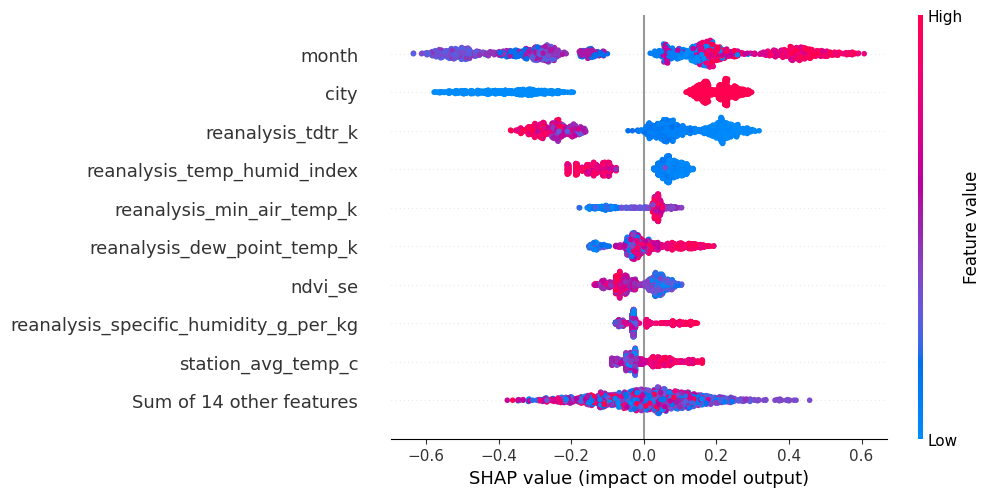

In [28]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(lgb_reg)
shap_values = explainer(train_features)

# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

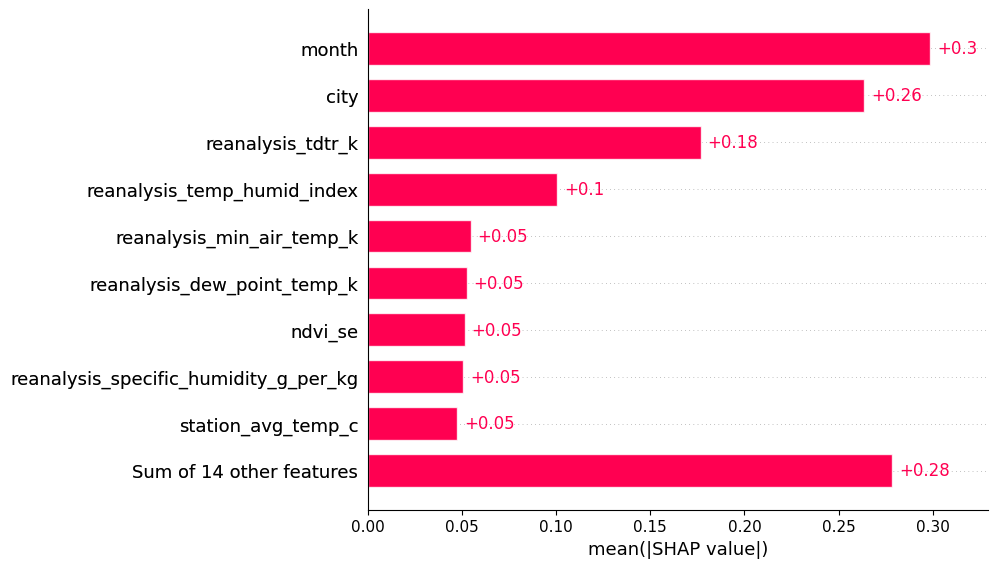

In [29]:
## SHAP importance for LightGBM
shap.plots.bar(shap_values)

In [35]:
## save best parameters
with open('Outputs/lgb_params.pickle', 'wb') as handle:
    pickle.dump(lgb_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### XGBoost

In [10]:
import xgboost as xgb

def xgb_objective_ts_cv(trial, train_features, train_labels):

  param_grid = {
      "n_estimators": trial.suggest_int("n_estimators", 20, 100, 10),
      "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, step=0.01),
      "max_depth": trial.suggest_int("max_depth", 3, 8),
      "subsample": trial.suggest_float("subsample", 0.7, 0.9, step=0.1),
      "min_child_weight": trial.suggest_int("min_child_weight", 5, 10, step=5),
      "colsample_bytree": trial.suggest_float(
          "colsample_bytree", 0.7, 0.95, step=0.05
      ),
      "colsample_bylevel": trial.suggest_float(
          "colsample_bylevel", 0.1, 0.3, step=0.05
      ),
      "reg_alpha": trial.suggest_float(
          "reg_alpha", 0.05, 0.2, step=0.05
      )
  }

  tscv = TimeSeriesSplit(n_splits=5)
  folds = tscv.split(train_features)
  folds_xgb = []

  for in_index, out_index in folds:
    folds_xgb.append((list(in_index), list(out_index)))

  dtrain = xgb.DMatrix(train_features, label=train_labels)

  param_grid['objective'] = "reg:squarederror"
  # param_grid['metric'] = "l1"
  param_grid['verbosity'] = 0
  param_grid['eta'] = 0.05
  param_grid['booster'] = "dart"

  xgbcv = xgb.cv(param_grid,
                 dtrain,
                 folds=folds_xgb,
                 early_stopping_rounds=50,
                 shuffle=False)

  cv_score = xgbcv['test-rmse-mean'].iloc[-1] + xgbcv['test-rmse-std'].iloc[-1]

  return cv_score

In [30]:
study = optuna.create_study(
        direction="minimize",
        study_name = "XGBoost"
    )
func = lambda trial: xgb_objective_ts_cv(trial, train_features, train_labels)
study.optimize(func, n_trials = 150)
xgb_parameters = study.best_params

xgb_reg = XGBRegressor(**xgb_parameters,
                        random_state = 42)
xgb_reg.fit(train_features, train_labels, eval_metric = mean_absolute_error)
Y_pred = np.expm1(xgb_reg.predict(validation_features)).astype(int).clip(0)

print("\n\nFinal MAE for validation set is {}".format(mean_absolute_error(validation_labels, Y_pred)))

[I 2023-10-30 04:13:35,571] A new study created in memory with name: XGBoost
[I 2023-10-30 04:13:35,698] Trial 0 finished with value: 1.4905185343430523 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 6, 'subsample': 0.7999999999999999, 'min_child_weight': 10, 'colsample_bytree': 0.75, 'colsample_bylevel': 0.1, 'reg_alpha': 0.2}. Best is trial 0 with value: 1.4905185343430523.
[I 2023-10-30 04:13:35,808] Trial 1 finished with value: 1.3631867233792994 and parameters: {'n_estimators': 70, 'learning_rate': 0.115, 'max_depth': 5, 'subsample': 0.7, 'min_child_weight': 10, 'colsample_bytree': 0.85, 'colsample_bylevel': 0.1, 'reg_alpha': 0.05}. Best is trial 1 with value: 1.3631867233792994.
[I 2023-10-30 04:13:35,905] Trial 2 finished with value: 1.36979161117814 and parameters: {'n_estimators': 70, 'learning_rate': 0.10500000000000001, 'max_depth': 3, 'subsample': 0.7999999999999999, 'min_child_weight': 10, 'colsample_bytree': 0.85, 'colsample_bylevel': 0.3, 'reg



Final MAE for validation set is 11.945205479452055


##### Hyperparameter Tuning

In [31]:
plot_slice(study)

In [32]:
plot_param_importances(study)

##### Feature Importance Analysis

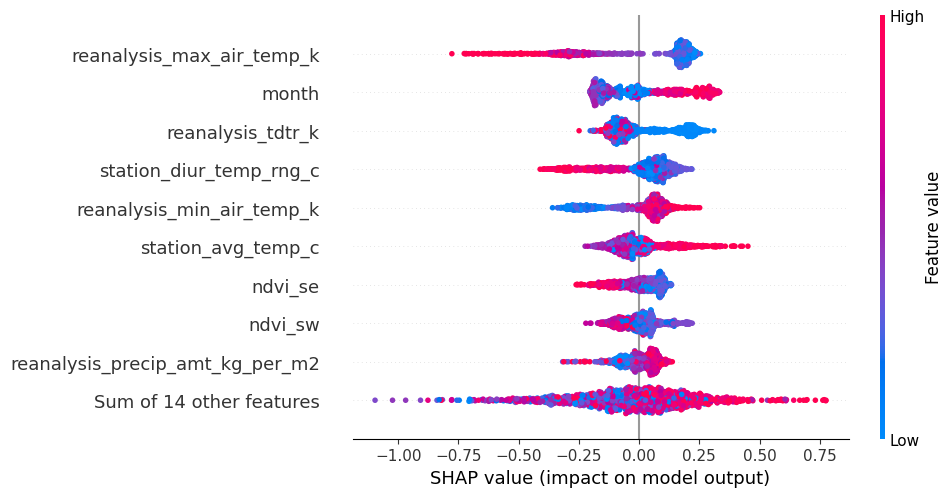

In [33]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(xgb_reg)
shap_values = explainer(train_features)

# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

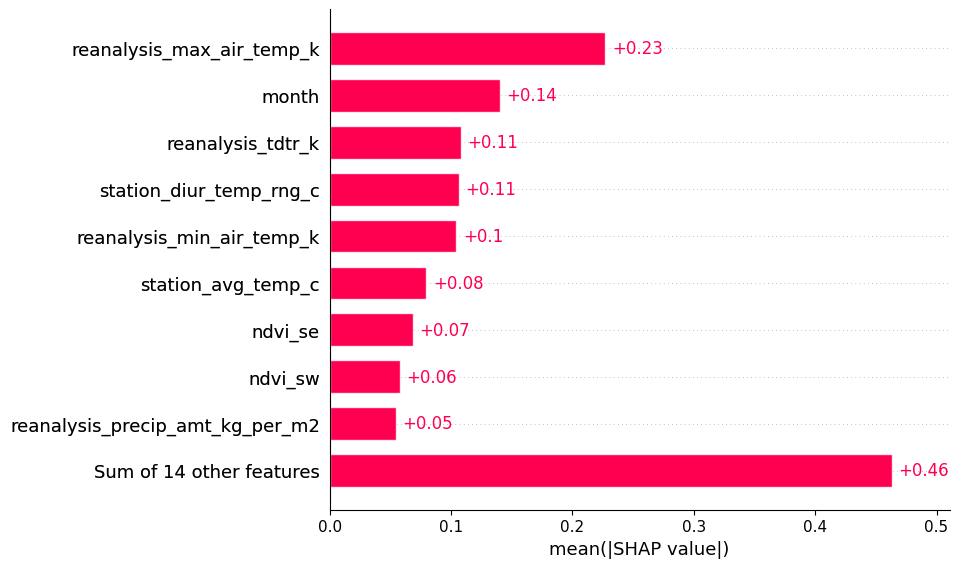

In [34]:
## SHAP importance for LightGBM
shap.plots.bar(shap_values)

In [36]:
## save best parameters
with open('Outputs/xgb_params.pickle', 'wb') as handle:
    pickle.dump(xgb_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
## read best parameters
with open('Outputs/xgb_params.pickle', 'rb') as handle:
    xgb_parameters = pickle.load(handle)

#### Submission

In [ ]:
from utils import feature_engineer

## skewed features
right_skew_col = ['precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_sat_precip_amt_mm', 'station_precip_mm']
left_skew_col = ['reanalysis_dew_point_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_relative_humidity_percent', 'station_min_temp_c']

test = pd.read_csv("Data/ProcessedData/dengue_features_test.csv")
test_features = pd.read_csv("Data/ProcessedData/dengue_features_test.csv")
test_features['month'] = pd.to_datetime(test_features['week_start_date']).dt.month
test_features = feature_engineer.feature_engineer_pipeline(test_features, right_skew_col=right_skew_col, left_skew_col=left_skew_col)

In [ ]:
test['total_cases'] = np.expm1(xgb_reg.predict(test_features)).astype(int).clip(0)
test[['city','year','weekofyear','total_cases']].to_csv('submission_lgb.csv', index=False)